In [2]:
from torchvision import datasets, transforms
import torch
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

from cnn_model import CNNModel
from vit_model import ViTModel

In [3]:
# we'll see if needed
# Define transforms to preprocess the data (you can customize these as needed)
TARGET_WIDTH = 224
TARGET_HEIGHT = 224

transform = transforms.Compose([
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    #transforms.Pad((111, 96, 112, 96), fill=0),  # Add Padding:  Our images are 64x33 (left,right,top, bottom)
    transforms.Pad((95,80, 96, 80), fill=0) # Add padding for ViT (target is 224*224)
])

In [4]:
# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)
validation_dataset = datasets.ImageFolder(root="dataset/validation", transform=transform)
test_dataset = datasets.ImageFolder(root="dataset/test", transform=transform)
train_dataset.class_to_idx, validation_dataset.class_to_idx, test_dataset.class_to_idx

({'holo': 0, 'non-holo': 1},
 {'holo': 0, 'non-holo': 1},
 {'holo': 0, 'non-holo': 1})

In [5]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(36000, 4500, 4500)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : holo


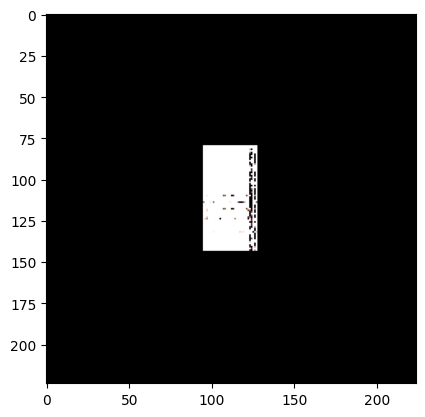

In [6]:
image_index = 0
plt.imshow(train_dataset[image_index][0].permute(1, 2, 0))
print(f"label : {train_dataset.classes[train_dataset[image_index][1]]}")
#Normalization will cause the colors to be off or to be impossible to read by imshow

In [7]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [8]:
# Define DataLoader for each split using the respective sampler
training_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True )
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [9]:
#model = CNNModel(num_classes=1,
#                 lr=0.0001)
model = ViTModel(num_classes=1,
                 lr=0.0001)

In [10]:
model

CNNModel(
  (pretrained_mobilenet): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(16, 8, kernel_si

In [11]:
checkpoint_callback = ModelCheckpoint(
        dirpath="models",
        monitor="validation_accuracy",
        filename="best",
        mode="max",
        save_last=True,
        verbose=True
    )
# train the model
trainer = L.Trainer(max_epochs=10,
                    log_every_n_steps=1,
                    val_check_interval=0.25,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model=model, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/yanis/paris_cite/S2/TER/model_training/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | pretrained_mobilenet | MobileNetV3    | 569 K 
1 | accuracy_metric      | BinaryAccuracy | 0     
--------------------------------------------------------
569 K     Trainable params
0         Non-trainable params
569 K     Total params
2.27

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:  25%|██▍       | 70/282 [00:19<00:59,  3.56it/s, v_num=1, train_accuracy_step=0.711, validation_loss=0.673, validation_accuracy=0.598]

Epoch 0, global step 70: 'validation_accuracy' reached 0.59844 (best 0.59844), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0:  50%|████▉     | 140/282 [00:37<00:38,  3.70it/s, v_num=1, train_accuracy_step=0.633, validation_loss=0.654, validation_accuracy=0.622]

Epoch 0, global step 140: 'validation_accuracy' reached 0.62222 (best 0.62222), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0:  74%|███████▍  | 210/282 [00:55<00:19,  3.77it/s, v_num=1, train_accuracy_step=0.656, validation_loss=0.642, validation_accuracy=0.628]

Epoch 0, global step 210: 'validation_accuracy' reached 0.62800 (best 0.62800), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0:  99%|█████████▉| 280/282 [01:13<00:00,  3.80it/s, v_num=1, train_accuracy_step=0.672, validation_loss=0.661, validation_accuracy=0.594]

Epoch 0, global step 280: 'validation_accuracy' was not in top 1


Epoch 1:  25%|██▍       | 70/282 [00:13<00:41,  5.05it/s, v_num=1, train_accuracy_step=0.672, validation_loss=0.661, validation_accuracy=0.610, train_accuracy_epoch=0.615] 

Epoch 1, global step 352: 'validation_accuracy' was not in top 1


Epoch 1:  50%|████▉     | 140/282 [00:26<00:27,  5.19it/s, v_num=1, train_accuracy_step=0.742, validation_loss=0.720, validation_accuracy=0.554, train_accuracy_epoch=0.615]

Epoch 1, global step 422: 'validation_accuracy' was not in top 1


Epoch 1:  74%|███████▍  | 210/282 [00:40<00:13,  5.17it/s, v_num=1, train_accuracy_step=0.711, validation_loss=0.615, validation_accuracy=0.650, train_accuracy_epoch=0.615]

Epoch 1, global step 492: 'validation_accuracy' reached 0.64978 (best 0.64978), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 1:  99%|█████████▉| 280/282 [00:54<00:00,  5.18it/s, v_num=1, train_accuracy_step=0.617, validation_loss=0.610, validation_accuracy=0.670, train_accuracy_epoch=0.615]

Epoch 1, global step 562: 'validation_accuracy' reached 0.66978 (best 0.66978), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 2:  25%|██▍       | 70/282 [00:13<00:40,  5.22it/s, v_num=1, train_accuracy_step=0.672, validation_loss=0.599, validation_accuracy=0.664, train_accuracy_epoch=0.669] 

Epoch 2, global step 634: 'validation_accuracy' was not in top 1


Epoch 2:  50%|████▉     | 140/282 [00:27<00:27,  5.18it/s, v_num=1, train_accuracy_step=0.742, validation_loss=0.647, validation_accuracy=0.637, train_accuracy_epoch=0.669]

Epoch 2, global step 704: 'validation_accuracy' was not in top 1


Epoch 2:  74%|███████▍  | 210/282 [00:40<00:13,  5.24it/s, v_num=1, train_accuracy_step=0.672, validation_loss=0.646, validation_accuracy=0.642, train_accuracy_epoch=0.669]

Epoch 2, global step 774: 'validation_accuracy' was not in top 1


Epoch 2:  99%|█████████▉| 280/282 [00:53<00:00,  5.22it/s, v_num=1, train_accuracy_step=0.695, validation_loss=0.597, validation_accuracy=0.671, train_accuracy_epoch=0.669]

Epoch 2, global step 844: 'validation_accuracy' reached 0.67111 (best 0.67111), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 3:  25%|██▍       | 70/282 [00:15<00:46,  4.55it/s, v_num=1, train_accuracy_step=0.648, validation_loss=0.689, validation_accuracy=0.603, train_accuracy_epoch=0.686] 

Epoch 3, global step 916: 'validation_accuracy' was not in top 1


Epoch 3:  50%|████▉     | 140/282 [00:32<00:32,  4.31it/s, v_num=1, train_accuracy_step=0.688, validation_loss=0.598, validation_accuracy=0.674, train_accuracy_epoch=0.686]

Epoch 3, global step 986: 'validation_accuracy' reached 0.67356 (best 0.67356), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 3:  74%|███████▍  | 210/282 [00:47<00:16,  4.46it/s, v_num=1, train_accuracy_step=0.758, validation_loss=0.777, validation_accuracy=0.538, train_accuracy_epoch=0.686]

Epoch 3, global step 1056: 'validation_accuracy' was not in top 1


Epoch 3:  99%|█████████▉| 280/282 [01:00<00:00,  4.63it/s, v_num=1, train_accuracy_step=0.633, validation_loss=0.685, validation_accuracy=0.609, train_accuracy_epoch=0.686]

Epoch 3, global step 1126: 'validation_accuracy' was not in top 1


Epoch 4:  25%|██▍       | 70/282 [00:13<00:40,  5.17it/s, v_num=1, train_accuracy_step=0.703, validation_loss=0.725, validation_accuracy=0.578, train_accuracy_epoch=0.698] 

Epoch 4, global step 1198: 'validation_accuracy' was not in top 1


Epoch 4:  50%|████▉     | 140/282 [00:26<00:27,  5.21it/s, v_num=1, train_accuracy_step=0.750, validation_loss=0.752, validation_accuracy=0.567, train_accuracy_epoch=0.698]

Epoch 4, global step 1268: 'validation_accuracy' was not in top 1


Epoch 4:  74%|███████▍  | 210/282 [00:40<00:13,  5.24it/s, v_num=1, train_accuracy_step=0.648, validation_loss=0.769, validation_accuracy=0.549, train_accuracy_epoch=0.698]

Epoch 4, global step 1338: 'validation_accuracy' was not in top 1


Epoch 4:  99%|█████████▉| 280/282 [00:53<00:00,  5.19it/s, v_num=1, train_accuracy_step=0.672, validation_loss=0.764, validation_accuracy=0.558, train_accuracy_epoch=0.698]

Epoch 4, global step 1408: 'validation_accuracy' was not in top 1


Epoch 5:  25%|██▍       | 70/282 [00:13<00:40,  5.22it/s, v_num=1, train_accuracy_step=0.750, validation_loss=0.592, validation_accuracy=0.684, train_accuracy_epoch=0.709] 

Epoch 5, global step 1480: 'validation_accuracy' reached 0.68378 (best 0.68378), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 5:  50%|████▉     | 140/282 [00:27<00:27,  5.16it/s, v_num=1, train_accuracy_step=0.688, validation_loss=0.672, validation_accuracy=0.624, train_accuracy_epoch=0.709]

Epoch 5, global step 1550: 'validation_accuracy' was not in top 1


Epoch 5:  74%|███████▍  | 210/282 [00:40<00:13,  5.20it/s, v_num=1, train_accuracy_step=0.781, validation_loss=0.726, validation_accuracy=0.595, train_accuracy_epoch=0.709]

Epoch 5, global step 1620: 'validation_accuracy' was not in top 1


Epoch 5:  99%|█████████▉| 280/282 [00:54<00:00,  5.18it/s, v_num=1, train_accuracy_step=0.742, validation_loss=0.615, validation_accuracy=0.672, train_accuracy_epoch=0.709]

Epoch 5, global step 1690: 'validation_accuracy' was not in top 1


Epoch 6:  25%|██▍       | 70/282 [00:13<00:40,  5.18it/s, v_num=1, train_accuracy_step=0.734, validation_loss=0.771, validation_accuracy=0.566, train_accuracy_epoch=0.713] 

Epoch 6, global step 1762: 'validation_accuracy' was not in top 1


Epoch 6:  50%|████▉     | 140/282 [00:27<00:27,  5.10it/s, v_num=1, train_accuracy_step=0.727, validation_loss=0.590, validation_accuracy=0.687, train_accuracy_epoch=0.713]

Epoch 6, global step 1832: 'validation_accuracy' reached 0.68733 (best 0.68733), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 6:  74%|███████▍  | 210/282 [00:41<00:14,  5.04it/s, v_num=1, train_accuracy_step=0.703, validation_loss=0.748, validation_accuracy=0.544, train_accuracy_epoch=0.713]

Epoch 6, global step 1902: 'validation_accuracy' was not in top 1


Epoch 6:  99%|█████████▉| 280/282 [00:55<00:00,  5.08it/s, v_num=1, train_accuracy_step=0.766, validation_loss=0.806, validation_accuracy=0.560, train_accuracy_epoch=0.713]

Epoch 6, global step 1972: 'validation_accuracy' was not in top 1


Epoch 7:  25%|██▍       | 70/282 [00:13<00:40,  5.20it/s, v_num=1, train_accuracy_step=0.703, validation_loss=0.598, validation_accuracy=0.681, train_accuracy_epoch=0.720] 

Epoch 7, global step 2044: 'validation_accuracy' was not in top 1


Epoch 7:  50%|████▉     | 140/282 [00:27<00:27,  5.18it/s, v_num=1, train_accuracy_step=0.711, validation_loss=0.584, validation_accuracy=0.696, train_accuracy_epoch=0.720]

Epoch 7, global step 2114: 'validation_accuracy' reached 0.69622 (best 0.69622), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 7:  74%|███████▍  | 210/282 [00:40<00:14,  5.13it/s, v_num=1, train_accuracy_step=0.781, validation_loss=0.601, validation_accuracy=0.678, train_accuracy_epoch=0.720]

Epoch 7, global step 2184: 'validation_accuracy' was not in top 1


Epoch 7:  99%|█████████▉| 280/282 [00:54<00:00,  5.16it/s, v_num=1, train_accuracy_step=0.727, validation_loss=0.707, validation_accuracy=0.620, train_accuracy_epoch=0.720]

Epoch 7, global step 2254: 'validation_accuracy' was not in top 1


Epoch 8:  25%|██▍       | 70/282 [00:13<00:40,  5.29it/s, v_num=1, train_accuracy_step=0.766, validation_loss=0.658, validation_accuracy=0.639, train_accuracy_epoch=0.724] 

Epoch 8, global step 2326: 'validation_accuracy' was not in top 1


Epoch 8:  50%|████▉     | 140/282 [00:27<00:27,  5.18it/s, v_num=1, train_accuracy_step=0.797, validation_loss=0.805, validation_accuracy=0.573, train_accuracy_epoch=0.724]

Epoch 8, global step 2396: 'validation_accuracy' was not in top 1


Epoch 8:  74%|███████▍  | 210/282 [00:40<00:14,  5.14it/s, v_num=1, train_accuracy_step=0.750, validation_loss=0.691, validation_accuracy=0.615, train_accuracy_epoch=0.724]

Epoch 8, global step 2466: 'validation_accuracy' was not in top 1


Epoch 8:  99%|█████████▉| 280/282 [00:54<00:00,  5.13it/s, v_num=1, train_accuracy_step=0.766, validation_loss=0.592, validation_accuracy=0.688, train_accuracy_epoch=0.724]

Epoch 8, global step 2536: 'validation_accuracy' was not in top 1


Epoch 9:  25%|██▍       | 70/282 [00:13<00:41,  5.05it/s, v_num=1, train_accuracy_step=0.742, validation_loss=0.757, validation_accuracy=0.598, train_accuracy_epoch=0.732] 

Epoch 9, global step 2608: 'validation_accuracy' was not in top 1


Epoch 9:  50%|████▉     | 140/282 [00:27<00:28,  5.01it/s, v_num=1, train_accuracy_step=0.742, validation_loss=0.695, validation_accuracy=0.642, train_accuracy_epoch=0.732]

Epoch 9, global step 2678: 'validation_accuracy' was not in top 1


Epoch 9:  74%|███████▍  | 210/282 [00:41<00:14,  5.02it/s, v_num=1, train_accuracy_step=0.695, validation_loss=0.580, validation_accuracy=0.693, train_accuracy_epoch=0.732]

Epoch 9, global step 2748: 'validation_accuracy' was not in top 1


Epoch 9:  99%|█████████▉| 280/282 [00:55<00:00,  5.02it/s, v_num=1, train_accuracy_step=0.727, validation_loss=0.582, validation_accuracy=0.697, train_accuracy_epoch=0.732]

Epoch 9, global step 2818: 'validation_accuracy' reached 0.69733 (best 0.69733), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 9: 100%|██████████| 282/282 [00:56<00:00,  5.03it/s, v_num=1, train_accuracy_step=0.625, validation_loss=0.582, validation_accuracy=0.697, train_accuracy_epoch=0.738]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 282/282 [00:56<00:00,  5.02it/s, v_num=1, train_accuracy_step=0.625, validation_loss=0.582, validation_accuracy=0.697, train_accuracy_epoch=0.738]


In [12]:
#print(f"Loading model best.ckpt")
#best_model = CNNModel.load_from_checkpoint("models/best.ckpt", num_classes=1, lr=0.0001).to('cuda')
#best_model

In [13]:
print(f"Loading model best.ckpt")
best_model = ViTModel.load_from_checkpoint("models/best-ViT.ckpt", num_classes=1, lr=0.0001).to('cuda')
#best_model = CNNModel.load_from_checkpoint("models/best-CNN.ckpt", num_classes=1, lr=0.0001).to('cuda')
best_model

Loading model best.ckpt


CNNModel(
  (pretrained_mobilenet): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(16, 8, kernel_si

In [14]:
trainer.test(model=best_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 36/36 [00:05<00:00,  7.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6966666579246521
        test_loss           0.5684449076652527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5684449076652527, 'test_accuracy': 0.6966666579246521}]

In [25]:
input, label = next(iter(test_dataloader))

In [26]:
input = input.to('cuda')
input.shape

torch.Size([128, 3, 224, 224])

In [27]:
label = label.to('cuda')
label.shape

torch.Size([128])

In [28]:
# For every INPUT_SIZE / Prediction size do the prediction then append
best_model.eval()
with torch.no_grad():
        #input = input.unsqueeze(0).to('cpu')
        #print(input)
        y_hat = best_model(input).squeeze()
        result = torch.nn.functional.sigmoid(y_hat)
# Output the last 100 of the result

In [29]:
result

tensor([0.9351, 0.9714, 0.3627, 0.1418, 0.5261, 0.9647, 0.6980, 0.4075, 0.7207,
        0.5179, 0.0435, 0.5058, 0.0073, 0.9472, 0.8690, 0.5513, 0.9751, 0.9591,
        0.6555, 0.8751, 0.8892, 0.6918, 0.4900, 0.0498, 0.7538, 0.9683, 0.6867,
        0.9061, 0.9249, 0.9157, 0.1855, 0.7719, 0.9694, 0.7420, 0.9255, 0.0397,
        0.7750, 0.8253, 0.6235, 0.6668, 0.6615, 0.2057, 0.2617, 0.0080, 0.8687,
        0.9533, 0.3209, 0.0161, 0.0356, 0.0656, 0.9721, 0.9669, 0.2779, 0.8716,
        0.9646, 0.3607, 0.9113, 0.9637, 0.9039, 0.7049, 0.5602, 0.6361, 0.0273,
        0.9400, 0.2535, 0.7930, 0.0390, 0.8970, 0.9526, 0.9416, 0.4072, 0.0072,
        0.0093, 0.3741, 0.9503, 0.3566, 0.8670, 0.3487, 0.1036, 0.4163, 0.9888,
        0.9069, 0.7401, 0.0678, 0.9539, 0.4978, 0.8160, 0.9348, 0.8016, 0.9649,
        0.9311, 0.2102, 0.9488, 0.0719, 0.9170, 0.8647, 0.8692, 0.5067, 0.3115,
        0.0758, 0.9592, 0.4297, 0.9075, 0.0162, 0.2135, 0.7954, 0.1990, 0.0786,
        0.0626, 0.7620, 0.0085, 0.0726, 

In [30]:
label

tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')